In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, time
import numpy as np
from first_gm import plot_SM, plot_raster, gaussian_kernel, tensor2spikeship

## Raster plot generative model with a superposition of SMs
### Parameters

In [3]:
class world_params:
    N_pre = 50 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 2 # number of SM used for RP generation
    
    p_input = .1 # probability of having spike for the input
    SM_ratio = 10 # coefficient that gives the SM/noise spike ratio
    N_timesteps =  2**8 # number of timesteps in the RP
    
    p_spontaneous = p_input/(1+SM_ratio) # probability of the spontaneous activity
    
    # TODO define all this better to work only with probability values
    avg_N_spikes = N_delays*N_pre*p_spontaneous # average number of spikes per SM
    std_N_spikes = 1 # variance for the number of spikes per SM
    
    #p_sm = p_input*SM_ratio/(1+SM_ratio)
    p_output = p_input*SM_ratio/((1+SM_ratio)*avg_N_spikes)
    
    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision
    
    seed = 4815162342 # seed

In [4]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        if add_coef:
            self.kernels = torch.zeros(self.opt.N_kernels+1, self.opt.N_pre, self.opt.N_delays)
        else:
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
            
        for k in range(self.kernels.shape[0]):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            if self.kernels[k, :, :].max()>1: self.kernels[k, :,:]/=self.kernels[k, :, :].max()
        if add_coef:
            self.kernels[-1, :, :] = (1-add_coef)*self.kernels[0, :, :] + add_coef*self.kernels[1, :, :]
                
    def draw_input_one_sm(self, N_trials = 1, do_channels = False, p_combined = 0):
        
        spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)
        
        output_rp = torch.zeros(N_trials, self.kernels.shape[0], self.opt.N_timesteps)
        address_output, time_output = torch.randint(self.opt.N_kernels, [N_trials]), torch.randint(self.opt.N_delays, self.opt.N_timesteps, [N_trials])
        output_rp[torch.arange(N_trials),address_output, time_output] = 1
    
        if p_combined > 0:
            do_combined = torch.bernoulli(torch.ones([N_trials])*p_combined)
            time_combined = torch.randint(self.opt.N_delays, self.opt.N_timesteps, [N_trials])
            non_overlapping_ind = np.where(((time_output-time_combined)*do_combined).abs()>self.opt.N_delays)[0]
            output_rp[non_overlapping_ind,torch.ones([len(non_overlapping_ind)], dtype=torch.int64)*(self.kernels.shape[0]-1), time_combined[non_overlapping_ind]] = 1
        
        input_sm_proba = torch.conv_transpose1d(output_rp, self.kernels)
        input_sm_proba = torch.roll(input_sm_proba, -self.kernels.shape[2], dims=2)[:,:,:-self.kernels.shape[2]+1]
        
        input_rp = torch.bernoulli(torch.minimum(input_sm_proba, torch.ones_like(input_sm_proba))) + spontaneous_activity
        
        if do_channels:
            input_rp_with_channels = torch.zeros(self.kernels.shape[0]+1, N_trials, self.opt.N_pre, self.opt.N_timesteps)
            input_rp_with_channels[0,:,:,:] = spontaneous_activity
            for sm in range(self.kernels.shape[0]):
                output_rp_with_channels = torch.zeros(N_trials, self.kernels.shape[0], self.opt.N_timesteps)
                output_rp_with_channels[:,sm,:] = output_rp[:,sm,:]
                input_sm_proba_with_channels = torch.conv_transpose1d(output_rp_with_channels, self.kernels)
                input_sm_proba_with_channels = torch.roll(input_sm_proba_with_channels, -self.kernels.shape[2], dims=2)[:,:,:-self.kernels.shape[2]+1]
                input_rp_with_channels[sm+1,:,:,:] = torch.bernoulli(torch.minimum(input_sm_proba_with_channels, torch.ones_like(input_sm_proba_with_channels)))
        
            return input_rp, output_rp, input_rp_with_channels
        else:
            return input_rp, output_rp

TODO: change something in the formula with SM_ratio

### Generative model without motif non overlapping

In [5]:
N_trials = 10
add_coef = .2

opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, output_rp, input_rp_with_channels = world.draw_input_one_sm(N_trials = N_trials, p_combined=.5, do_channels = True)

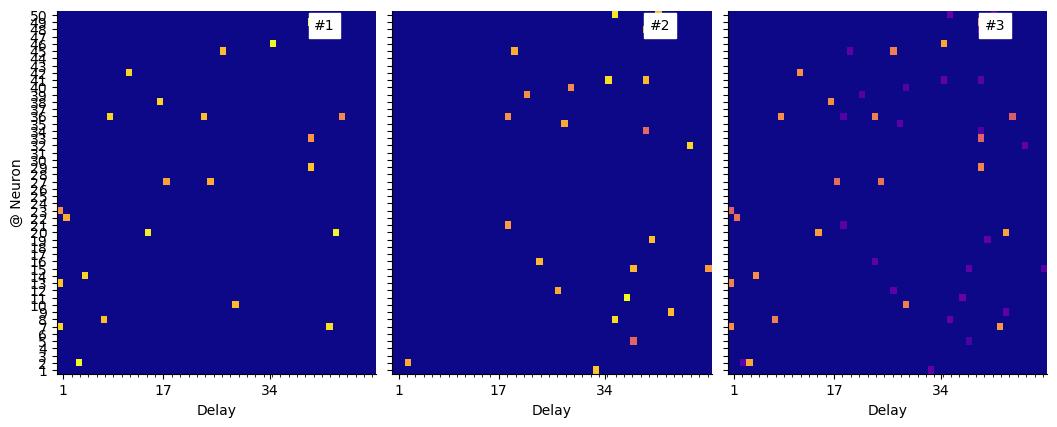

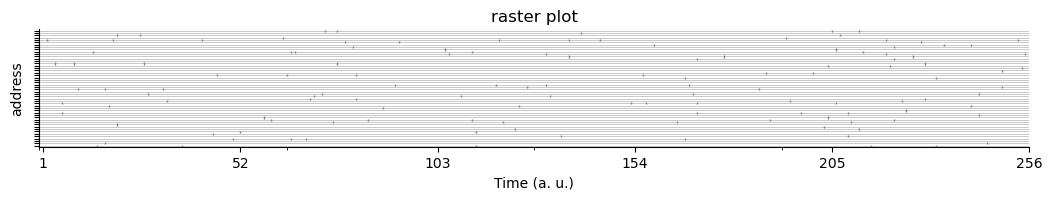

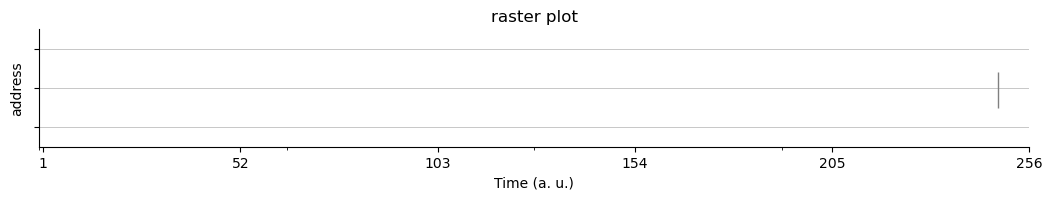

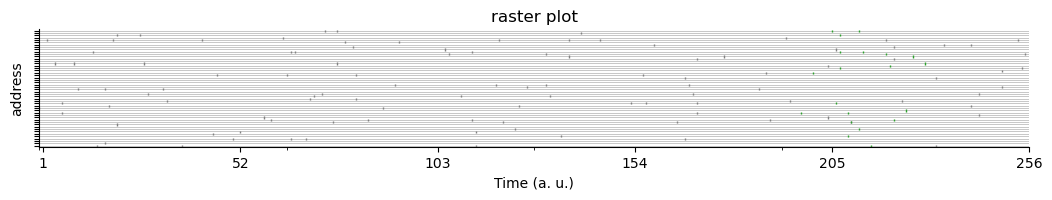

In [6]:
plot_SM(world.kernels, N_show = opt.N_kernels+1, figsize = (12, 5));
plot_raster(input_rp, colored=False);
plot_raster(output_rp, colored=False);
plot_raster(input_rp_with_channels, colored=True);

In [7]:
spike_times, ii_spike_times = tensor2spikeship(input_rp)

  0%|          | 0/10 [00:00<?, ?it/s]